In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import collections 
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from numba import jit, vectorize, float64, int64

In [3]:
@jit 

def jit_kmeans_pp(data, k, weights):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C


In [4]:
@jit
def jit_get_weight(C, data): 
    weights=np.zeros(C.shape[0])
    cdist = (jit_distance(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights


In [5]:
@jit
def jit_kmeans_II(data, k, l, max_iter=10000):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (jit_distance(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return jit_kmeans_pp(C, k, weights)


1st real world data: Housing data 

Reference :http://ichrome.com/blogs/archives/221

In [7]:
housing = np.loadtxt("../data/housing.data.txt")

In [8]:
#the sixth column is average number of rooms per dwelling
room = housing[:,5].reshape(-1,1)
#the last column is Median value of owner-occupied homes in $1000's
value = housing[:,-1].reshape(-1,1)

In [9]:
data = housing[:,(5,-1)]

In [10]:
def cdist_kmeans(data, k, centroids, max_iter=10000):
    
    for i in range(max_iter):
        cdist = (dist.cdist(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return centroids

In [11]:
def cdist_kmeans_pp(data, k, weights):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

In [12]:
def cdist_get_weight(C, data): 
    weights=np.zeros(C.shape[0])
    cdist = (dist.cdist(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights

In [13]:
def cdist_kmeans_II(data, k, l, max_iter=10000):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (dist.cdist(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= cdist_get_weight(C, data)

    return cdist_kmeans_pp(C, k, weights)

In [14]:
def navie_result(data, k, l):
    
    #find the initial center
    c  = np.random.choice(np.arange(len(data)), k)
    #base
    c0 = np.empty([k, data.shape[1]])
    c1 = data[c,:]
    c2 = cdist_kmeans_pp(data, k, 1)
    c3 = cdist_kmeans_II(data, k, l, max_iter = 10000)
    
    initial_centroid = np.array([c0, c1, c2, c3])
    
    
    label = np.empty([data.shape[0]])
    final_centroid = np.empty([k, data.shape[1]])
    for i in np.arange(1, 4):#three algorithm
        #kmeans_label = KMeans(n_clusters = k, init = initial_centroid[i], n_init = 1).fit_predict(data)
        output = cdist_kmeans(data,k ,initial_centroid[i])
        kmeans_label = output["Labels"]
        label = np.vstack([label, kmeans_label])
        kmeans_centroid = output["Centroids"]
        final_centroid = np.dstack((final_centroid, kmeans_centroid))

    
    return {"Initial_centroid":initial_centroid, "label":label, "Final_centroidtroid" :final_centroid }

In [15]:
dict = navie_result(data, 5, 10)

Algorithm converged after 7 iterations.
Algorithm converged after 12 iterations.
Algorithm converged after 6 iterations.


In [16]:
def test_cluster(ini_cen, fin_cen, label, data, title): 
    plt.scatter(data[:, 0], data[:, 1], c = label)
    for i in range(np.unique(label).size):
        if i > 0:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100)
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100)
        else:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100, label = "Initial Cluster")
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100, label = "Final Cluster")
    
    plt.legend(loc='best', prop={'size':15})
    plt.title(title)

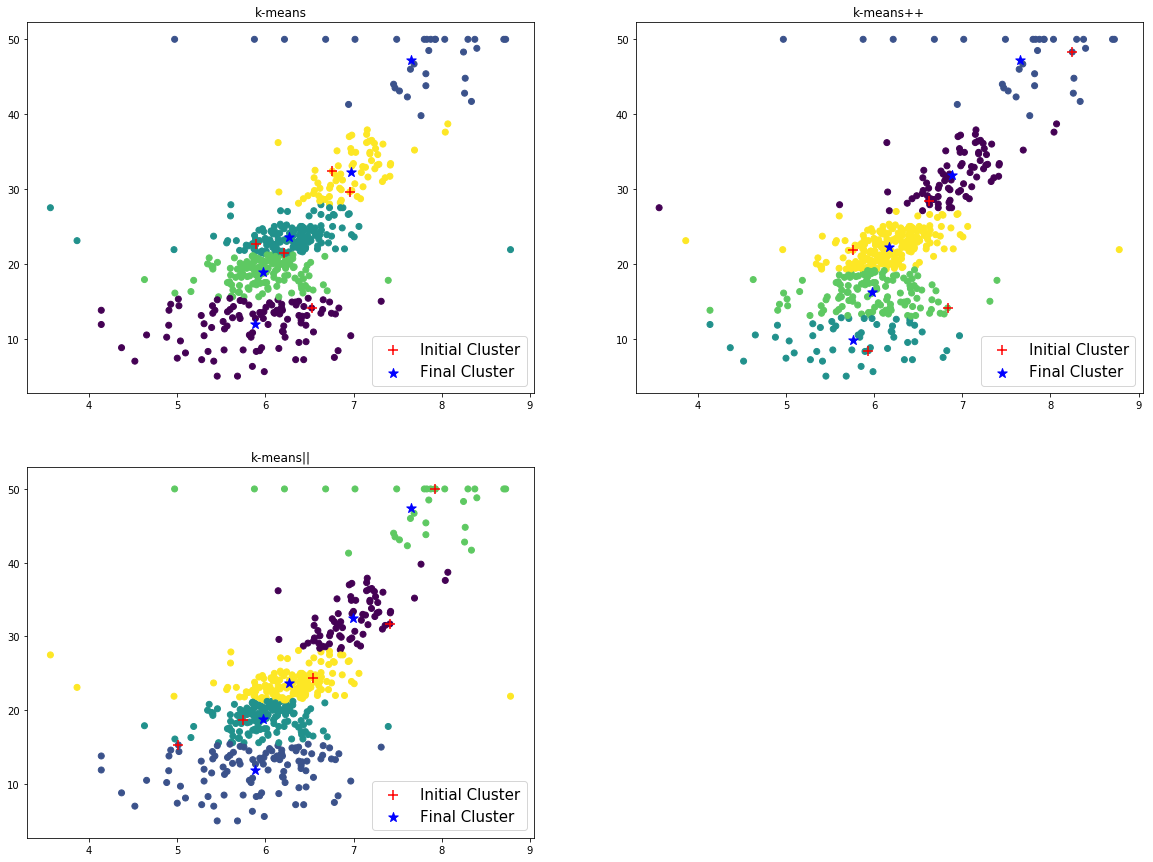

In [17]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict['Initial_centroid'][i], dict['Final_centroidtroid'][:,:,i], dict['label'][i],data, title[i - 1])
plt.show()

2nd real world data: spam

In [80]:
spam = pd.read_csv("data/spambase.data", header=None)
spam_np = np.asarray(spam)

In [87]:
d = spam.apply(np.ptp, axis = 0).to_dict()
sorted(d.items(), key = lambda x: x[1])[:5]

[(57, 1.0), (46, 2.17), (10, 2.61), (42, 3.57), (50, 4.081)]

In [82]:
dict1 = navie_result(spam_np, 5, 10)

Algorithm converged after 31 iterations.
Algorithm converged after 15 iterations.
Algorithm converged after 37 iterations.


In [88]:
def test_cluster(ini_cen, fin_cen, label, data, title): 
    plt.scatter(data[:, 10], data[:, 46], c = label)
    for i in range(np.unique(label).size):
        if i > 0:
            plt.scatter(ini_cen[i,10],ini_cen[i,46],marker = '+', c = 'red', s= 100)
            plt.scatter(fin_cen[i,10],fin_cen[i,46],marker = '*', c = 'blue', s= 100)
        else:
            plt.scatter(ini_cen[i,10],ini_cen[i,46],marker = '+', c = 'red', s= 100, label = "Initial Cluster")
            plt.scatter(fin_cen[i,10],fin_cen[i,46],marker = '*', c = 'blue', s= 100, label = "Final Cluster")
    
    plt.legend(loc='best', prop={'size':15})
    plt.title(title)

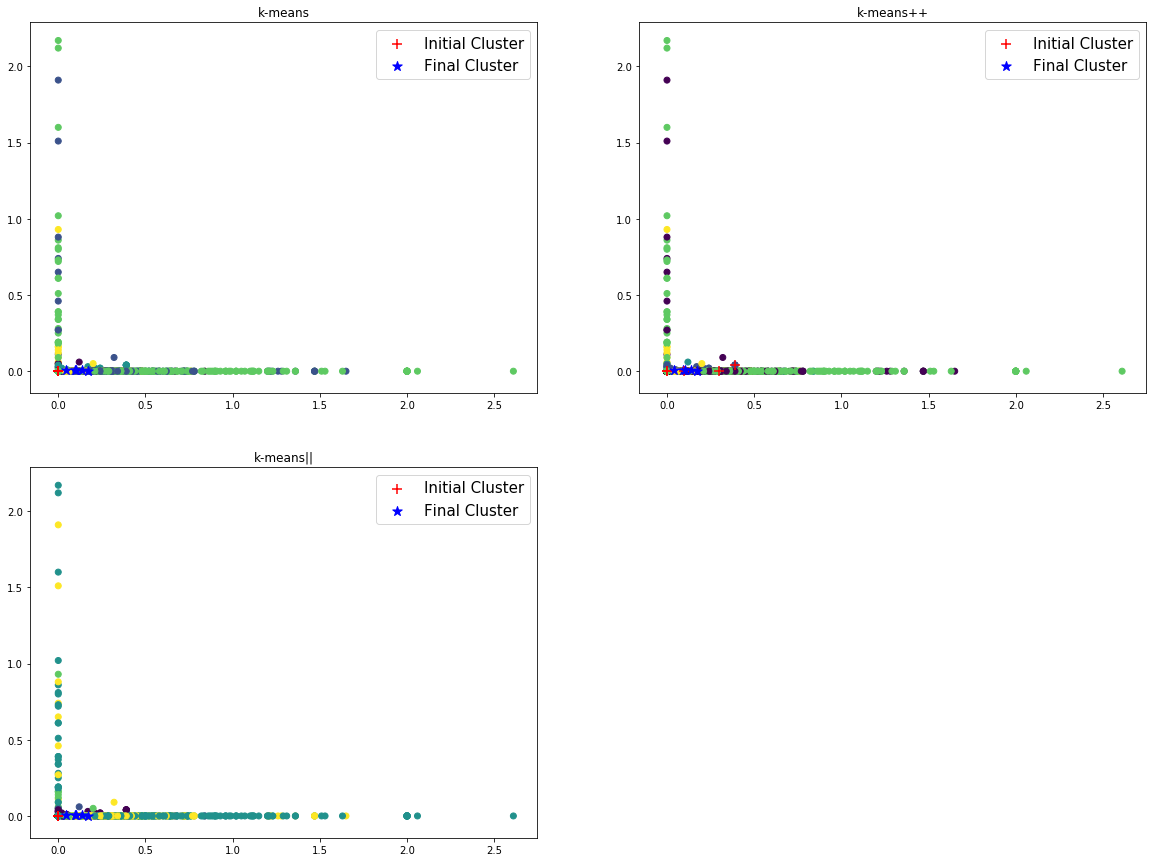

In [89]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict1['Initial_centroid'][i], dict1['Final_centroidtroid'][:,:,i], dict1['label'][i],spam_np, title[i - 1])
plt.show()